
# Wearable Fatigue Forecasting for Construction Workers

## Project Goal

The aim of this project is to predict how worker fatigue evolves over short-term horizons (next 5, 15, 30, and 60 minutes) using physiological data collected from wearable sensors. This allows supervisors or safety systems to proactively manage worker fatigue and reduce risks on the job.

## Data Overview

- **Dataset**: Time-series measurements from multiple workers.

Columns include:

- **worker_id**: unique identifier for each worker

- **time_s**: time in seconds from the start of observation

- **Physiological features**: heart rate (hr_bpm), heart rate variability (hrv_rmssd), muscle activation (emg_level), skin temperature (skin_temp_c), ambient temperature (ambient_temp_c)

- **fatigue_now**: current fatigue level (normalized 0–1)

**Fatigue scales**:

- 0–1: 0 = fully fresh, 1 = extremely fatigued

- ROF 1–10: scaled version used for easy interpretation:

- 1–3 = LOW fatigue

- 4–7 = MEDIUM fatigue

- 8–10 = HIGH fatigue



## 1) Load data

In [23]:

import pandas as pd
df_all = pd.read_csv(r"C:\Users\modes\Downloads\fatigue_site_timeseries.csv")
df_all.head()


,worker_id,time_s,hr_bpm,hrv_rmssd,emg_level,skin_temp_c,ambient_temp_c,fatigue_now
0,1,0,86.457076,51.693472,0.229361,33.575378,35,0.013346
1,1,1,84.470024,51.457892,0.200804,33.630358,35,0.000477
2,1,2,87.185677,51.035060,0.179728,33.517356,35,0.000000
3,1,3,87.500847,50.087178,0.213842,33.697980,35,0.020959
4,1,4,83.193447,48.871247,0.204447,33.367903,35,0.018902



**Columns**
- `worker_id` (repeats because time-series), `time_s` (seconds from start)
- Physio: `hr_bpm`, `hrv_rmssd`, `emg_level`, `skin_temp_c`, `ambient_temp_c`
- `fatigue_now` (0–1 label); in real life comes from ROF prompts normalized to 0–1.


## 2) Sequences (60s context → +5/+15/+30/+60 targets)

I used 60 seconds of historical physiological data to predict fatigue in the future.

**Target horizons**: 5, 15, 30, 60 minutes ahead.

For each worker, sequences of data are created, and the corresponding future fatigue values are extracted.

**Why this matters**: Models like LSTM need sequential data to understand temporal patterns.

In [24]:

import numpy as np, pandas as pd
feature_cols = ["hr_bpm","hrv_rmssd","emg_level","skin_temp_c","ambient_temp_c"]
target_col   = "fatigue_now"
CONTEXT_LEN  = 60
HORIZONS     = [5*60, 15*60, 30*60, 60*60]

def make_sequences_multi(df, context_len, feature_cols, target_col, horizons):
    X_seqs, Y_future, meta = [], [], []
    for wid, dfw in df.groupby("worker_id"):
        dfw = dfw.sort_values("time_s").reset_index(drop=True)
        T = len(dfw)
        for idx in range(T):
            st = idx - context_len + 1
            if st < 0: continue
            fut_idx = [idx + H for H in horizons]
            if any(fi >= T for fi in fut_idx): continue
            X = dfw.loc[st:idx, feature_cols].to_numpy(np.float32)
            y = dfw.loc[fut_idx, target_col].to_numpy(np.float32)
            X_seqs.append(X); Y_future.append(y)
            meta.append({"worker_id": int(wid),
                         "current_time_s": float(dfw.loc[idx,"time_s"]),
                         "predict_time_s": float(dfw.loc[idx,"time_s"] + horizons[-1])})
    return X_seqs, np.asarray(Y_future, np.float32), pd.DataFrame(meta)

X_seqs, Y_future, meta = make_sequences_multi(df_all, CONTEXT_LEN, feature_cols, target_col, HORIZONS)
len(X_seqs), X_seqs[0].shape, Y_future[0], meta.head()


(10623,
 (60, 5),
 array([0.36324182, 0.52315533, 0.68589854, 0.81252074], dtype=float32),
    worker_id  current_time_s  predict_time_s
 0          1            59.0          3659.0
 1          1            60.0          3660.0
 2          1            61.0          3661.0
 3          1            62.0          3662.0
 4          1            63.0          3663.0)

## 3) Train/val split + DataLoaders (80/20)

80% of sequences used for training, 20% for validation.

Data structured into batches for efficient model training.

Each batch contains:

- **Input**: 60 seconds of physiological features

- **Output**: multi-horizon fatigue predictions (4 values per sequence)

In [25]:

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

idx_tr, idx_vl = train_test_split(np.arange(len(X_seqs)), test_size=0.2, random_state=42)

def select_indices(X, Y, M, idxs):
    X_sel = [X[i] for i in idxs]
    Y_sel = Y[idxs]
    M_sel = M.iloc[idxs].reset_index(drop=True)
    return X_sel, Y_sel, M_sel

X_tr, Y_tr, meta_tr = select_indices(X_seqs, Y_future, meta, idx_tr)
X_vl, Y_vl, meta_vl = select_indices(X_seqs, Y_future, meta, idx_vl)

class FatigueDataset(Dataset):
    def __init__(self, X_list, Y_array):
        self.X = [np.asarray(w, np.float32) for w in X_list]
        self.Y = np.asarray(Y_array, np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.Y[i])

def collate_batch(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs,0), torch.stack(ys,0)

train_loader = DataLoader(FatigueDataset(X_tr, Y_tr), batch_size=32, shuffle=True,  collate_fn=collate_batch)
val_loader   = DataLoader(FatigueDataset(X_vl, Y_vl), batch_size=32, shuffle=False, collate_fn=collate_batch)

xb, yb = next(iter(train_loader))
xb.shape, yb.shape


(torch.Size([32, 60, 5]), torch.Size([32, 4]))

## 4) LSTM multi-horizon forecaster

LSTM (Long Short-Term Memory) network was chosen because it captures time-dependent patterns in sequential data.

- **Input**: last 60 seconds of wearable features

- **Output**: predicted fatigue for next 5, 15, 30, 60 minutes

- **Training loss**: Mean Squared Error (MSE), suitable for continuous values like fatigue.

In [26]:

import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_FEATS = len(feature_cols)
NUM_H     = len(HORIZONS)

class LSTMForecasterMH(nn.Module):
    def __init__(self, in_features=NUM_FEATS, hidden_size=64, num_layers=1, out_dim=NUM_H):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_size, num_layers=num_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, out_dim)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.head(h[-1])

model = LSTMForecasterMH().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()


## 5) Train (5 epochs for demo)

Trained over a small number of epochs for demonstration.

Both training and validation loss monitored.

Early results show that the model predicts future fatigue very accurately.

In [27]:

import numpy as np
for epoch in range(5):
    model.train(); tr=[]
    for xb, yb in train_loader:
        xb, yb = xb.to(device).float(), yb.to(device).float()
        opt.zero_grad()
        loss = lossf(model(xb), yb)
        loss.backward(); opt.step()
        tr.append(loss.item())
    model.eval(); vl=[]
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            vl.append(lossf(model(xb), yb).item())
    print(f"Epoch {epoch+1}: train MSE={np.mean(tr):.4f} | val MSE={np.mean(vl):.4f}")


Epoch 1: train MSE=0.0155 | val MSE=0.0002
Epoch 2: train MSE=0.0001 | val MSE=0.0001
Epoch 3: train MSE=0.0001 | val MSE=0.0001
Epoch 4: train MSE=0.0001 | val MSE=0.0001
Epoch 5: train MSE=0.0001 | val MSE=0.0001


## 6) Evaluation (regression, ROF, early warning)

Fatigue predictions converted to ROF scale (1–10) for human interpretability.

**Early-warning system**:

- **HIGH fatigue**: ROF ≥ 8

Alerts generated when predicted fatigue exceeds thresholds.

**Performance metrics**:

- AUROC / PR-AUC (discrimination)

- F1, Precision, Recall (classification quality)

- Brier score (calibration of predicted probabilities)

- Per-worker evaluation confirms the model works across multiple individuals.

In [28]:
import numpy as np

def fatigue_to_rof_arr(arr):
    """
    Convert array of fatigue values 0–1 to ROF scale 1–10
    """
    arr = np.clip(arr, 0.0, 1.0)
    rof = np.rint(1 + 9*arr).astype(int)
    rof = np.clip(rof, 1, 10)
    return rof


In [30]:
# Move model to eval mode
model.eval()
Y_true, Y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:  # using your validation loader
        xb, yb = xb.to(device).float(), yb.to(device).float()
        pred = model(xb)
        Y_true.append(yb.cpu().numpy())
        Y_pred.append(pred.cpu().numpy())

# Concatenate into arrays
Y_true = np.vstack(Y_true)
Y_pred = np.vstack(Y_pred)


In [31]:
print("\nEarly-warning (HIGH when ROF>=8)")
for j, H in enumerate(HORIZONS):
    y_true_high = (fatigue_to_rof_arr(Y_true[:, j]) >= 8).astype(int)
    y_score     = np.clip(Y_pred[:, j], 0.0, 1.0)

    # class balance diagnostics
    n_pos = int(y_true_high.sum())
    n_neg = int(len(y_true_high) - n_pos)
    print(f"H=+{H//60}m | positives={n_pos} negatives={n_neg}")

    # if only one class, skip AUROC/PR and report Brier
    uniq = np.unique(y_true_high)
    if uniq.size < 2:
        cls = "positives" if uniq[0] == 1 else "negatives"
        brier = brier_score_loss(y_true_high, y_score)
        print(f"  Skipping AUROC/PR/F1 (only {cls} present). Brier={brier:.3f}")
        continue

    # normal case: compute AUROC,a PR-AUC, best-F1 threshold
    auroc  = roc_auc_score(y_true_high, y_score)
    ap     = average_precision_score(y_true_high, y_score)
    precs, recs, ths = precision_recall_curve(y_true_high, y_score)
    f1s = 2 * (precs[:-1] * recs[:-1]) / np.clip(precs[:-1] + recs[:-1], 1e-9, None)
    best_idx = int(np.argmax(f1s)) if len(f1s) else 0
    best_th  = float(ths[best_idx]) if len(ths) else 0.5

    y_pred_high = (y_score >= best_th).astype(int)
    f1   = f1_score(y_true_high, y_pred_high, zero_division=0)
    p    = precision_score(y_true_high, y_pred_high, zero_division=0)
    r    = recall_score(y_true_high, y_pred_high, zero_division=0)
    brier = brier_score_loss(y_true_high, y_score)

    print(f"  AUROC={auroc:.3f}  PR-AUC={ap:.3f}  "
          f"Best-F1={f1:.3f} @thr={best_th:.2f}  P={p:.3f} R={r:.3f}  Brier={brier:.3f}")



Early-warning (HIGH when ROF>=8)
H=+5m | positives=1108 negatives=1017
  AUROC=0.999  PR-AUC=0.999  Best-F1=0.986 @thr=0.72  P=0.986 R=0.985  Brier=0.185
H=+15m | positives=1476 negatives=649
  AUROC=0.999  PR-AUC=1.000  Best-F1=0.989 @thr=0.72  P=0.987 R=0.991  Brier=0.151
H=+30m | positives=2041 negatives=84
  AUROC=0.994  PR-AUC=1.000  Best-F1=0.992 @thr=0.72  P=0.994 R=0.990  Brier=0.056
H=+60m | positives=2125 negatives=0
  Skipping AUROC/PR/F1 (only positives present). Brier=0.012


In [32]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

# worker ids aligned to samples
w_tr = meta_tr["worker_id"].to_numpy()
w_vl = meta_vl["worker_id"].to_numpy()

class FatigueDatasetWithW(Dataset):
    def __init__(self, X_list, Y_array, W_array):
        assert len(X_list)==len(Y_array)==len(W_array)
        self.X = [np.asarray(w, np.float32) for w in X_list]
        self.Y = np.asarray(Y_array, np.float32)
        self.W = np.asarray(W_array,  np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return (
            torch.from_numpy(self.X[i]),            # [T,F]
            torch.from_numpy(self.Y[i]),            # [H]
            torch.tensor(self.W[i], dtype=torch.int64)  # worker_id
        )

def collate_three(batch):
    xs, ys, ws = zip(*batch)
    return torch.stack(xs,0), torch.stack(ys,0), torch.stack(ws,0)

# Rebuild loaders (no need to retrain the model)
train_loader = DataLoader(FatigueDatasetWithW(X_tr, Y_tr, w_tr), batch_size=32, shuffle=True,  collate_fn=collate_three)
val_loader   = DataLoader(FatigueDatasetWithW(X_vl, Y_vl, w_vl), batch_size=32, shuffle=False, collate_fn=collate_three)

# sanity check
xb, yb, wid = next(iter(val_loader))
print("shapes:", xb.shape, yb.shape, wid.shape, "| first worker ids:", wid[:8].tolist())


shapes: torch.Size([32, 60, 5]) torch.Size([32, 4]) torch.Size([32]) | first worker ids: [1, 1, 1, 1, 1, 2, 1, 1]


In [33]:
import pandas as pd
model.eval()
records = []
with torch.no_grad():
    for xb, yb, wid in val_loader:
        yhat = model(xb.to(device).float()).cpu().numpy()  # [B,H]
        y    = yb.numpy()                                  # [B,H]
        w    = wid.numpy()                                 # [B]
        for i in range(len(w)):
            rec = {"worker_id": int(w[i])}
            for j, H in enumerate(HORIZONS):
                lbl = f"+{H//60}m"
                rec[f"true_{lbl}"] = float(y[i, j])
                rec[f"pred_{lbl}"] = float(yhat[i, j])
            records.append(rec)

dfm = pd.DataFrame(records)
dfm.head()


,worker_id,true_+5m,pred_+5m,true_+15m,pred_+15m,true_+30m,pred_+30m,true_+60m,pred_+60m
0,1,0.525318,0.515889,0.630921,0.631485,0.748553,0.748119,0.841841,0.840740
1,1,0.786464,0.786206,0.819474,0.818274,0.863216,0.864197,0.958661,0.956923
2,1,0.739983,0.739416,0.767191,0.764859,0.816344,0.821625,0.908790,0.905306
3,1,0.567833,0.593212,0.706295,0.709470,0.769545,0.765789,0.859799,0.863208
4,1,0.817745,0.817475,0.843161,0.846675,0.892563,0.892706,0.991780,0.987719


In [36]:
class FatigueDatasetWithW(Dataset):
    def __init__(self, X_list, Y_array, W_array):
        assert len(X_list)==len(Y_array)==len(W_array)
        self.X = [np.asarray(w, np.float32) for w in X_list]
        self.Y = np.asarray(Y_array, np.float32)
        self.W = np.asarray(W_array,  np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return (
            torch.from_numpy(self.X[i]),            # [T,F]
            torch.from_numpy(self.Y[i]),            # [H]
            torch.tensor(self.W[i], dtype=torch.int64)  # worker_id
        )

def collate_three(batch):
    xs, ys, ws = zip(*batch)
    return torch.stack(xs,0), torch.stack(ys,0), torch.stack(ws,0)

# Rebuild loaders
train_loader = DataLoader(FatigueDatasetWithW(X_tr, Y_tr, w_tr),
                          batch_size=32, shuffle=True, collate_fn=collate_three)
val_loader   = DataLoader(FatigueDatasetWithW(X_vl, Y_vl, w_vl),
                          batch_size=32, shuffle=False, collate_fn=collate_three)


In [37]:
import numpy as np

def to_high(arr):  # ROF >= 8
    return (np.rint(1 + 9*np.clip(arr,0,1)) >= 8).astype(int)

thr = 0.72
for H in HORIZONS:
    lbl = f"+{H//60}m"
    dfm[f"true_high_{lbl}"] = to_high(dfm[f"true_{lbl}"].values)
    dfm[f"score_{lbl}"]     = np.clip(dfm[f"pred_{lbl}"].values, 0, 1)
    dfm[f"pred_high_{lbl}"] = (dfm[f"score_{lbl}"] >= thr).astype(int)

    def per_worker_stats(g, label):
        tp = ((g[f"pred_high_{label}"]==1) & (g[f"true_high_{label}"]==1)).sum()
        pp = (g[f"pred_high_{label}"]==1).sum()
        pn = (g[f"true_high_{label}"]==1).sum()
        precision = tp / pp if pp>0 else np.nan
        recall    = tp / pn if pn>0 else np.nan
        return pd.Series({
            "precision": round(precision,3),
            "recall": round(recall,3),
            "alerts": int(pp),
            "positives": int(pn)
        })

    perw = dfm.groupby("worker_id").apply(per_worker_stats, lbl).reset_index()
    print(f"\nPer-worker metrics at {lbl} (thr={thr}):")
    print(perw.to_string(index=False))



Per-worker metrics at +5m (thr=0.72):
 worker_id  precision  recall  alerts  positives
         1      0.964   0.989   386.0      376.0
         2      0.983   0.981   363.0      364.0
         3      0.989   0.995   370.0      368.0

Per-worker metrics at +15m (thr=0.72):
 worker_id  precision  recall  alerts  positives
         1      0.984   0.990   492.0      489.0
         2      0.994   0.977   479.0      487.0
         3      0.996   0.984   494.0      500.0

Per-worker metrics at +30m (thr=0.72):
 worker_id  precision  recall  alerts  positives
         1      0.993   0.991   674.0      675.0
         2      0.997   0.976   665.0      679.0
         3      0.996   0.994   686.0      687.0

Per-worker metrics at +60m (thr=0.72):
 worker_id  precision  recall  alerts  positives
         1        1.0     1.0   702.0      702.0
         2        1.0     1.0   707.0      707.0
         3        1.0     1.0   716.0      716.0


## 7) Per-worker inference

In [38]:

def fatigue_to_rof(f):
    f = float(np.clip(f, 0.0, 1.0))
    rof = int(round(1 + 9*f))
    return max(1, min(10, rof))

def rof_band(rof):
    if rof <= 3: return "low"
    if rof <= 7: return "medium"
    return "high"

def predict_multi_horizon(model, df_worker, now_s):
    dfw = df_worker.sort_values("time_s").reset_index(drop=True)
    idx = int(dfw["time_s"].sub(now_s).abs().idxmin())
    st  = idx - CONTEXT_LEN + 1
    if st < 0: raise ValueError("Not enough history yet.")
    X   = dfw.loc[st:idx, feature_cols].to_numpy(np.float32)
    with torch.no_grad():
        yhat = model(torch.from_numpy(X).unsqueeze(0).to(device)).cpu().numpy()[0]
    now_f = float(dfw.loc[idx, target_col])
    out = {"time_now_s": float(dfw.loc[idx,"time_s"]), "fatigue_now": now_f, "pred": {}}
    for lbl, f in zip(["+5m","+15m","+30m","+60m"], yhat):
        r = fatigue_to_rof(f)
        out["pred"][lbl] = {"fatigue_0_1": float(f), "rof_1_10": r, "band": rof_band(r)}
    return out

df_w_random = df_all[df_all.worker_id==np.random.choice(df_all.worker_id.unique())].copy()
res = predict_multi_horizon(model, df_w_random, now_s=int(df_w_random['time_s'].median()))
res


{'time_now_s': 3599.0,
 'fatigue_now': 0.8077344138056196,
 'pred': {'+5m': {'fatigue_0_1': 0.8239008188247681,
   'rof_1_10': 8,
   'band': 'high'},
  '+15m': {'fatigue_0_1': 0.8525494337081909, 'rof_1_10': 9, 'band': 'high'},
  '+30m': {'fatigue_0_1': 0.8968048095703125, 'rof_1_10': 9, 'band': 'high'},
  '+60m': {'fatigue_0_1': 0.9986722469329834, 'rof_1_10': 10, 'band': 'high'}}}

In [39]:
# ==== QUICK TEST (self-contained): forecast + supervisor note for a worker ====
import numpy as np, pandas as pd, torch

# --- If these exist already, this just reuses them:
# Needs: df_all, model, feature_cols, HORIZONS, CONTEXT_LEN, device
# If any are missing, define them here:
try:
    df_all
    model
    feature_cols
    HORIZONS
    CONTEXT_LEN
    device
except NameError as e:
    raise RuntimeError(f"Missing a required variable: {e}. "
                       f"Please run the earlier setup cells that define df_all/model/feature_cols/HORIZONS/CONTEXT_LEN/device.")

# --- Mapping helpers (fatigue 0–1 -> ROF 1–10 & band)
def fatigue_to_rof(f):
    f = float(np.clip(f, 0.0, 1.0))
    return int(max(1, min(10, round(1 + 9*f))))

def rof_band(rof):
    if rof <= 3: return "LOW"
    if rof <= 7: return "MEDIUM"
    return "HIGH"

# --- Core predictor (uses your trained model)
def predict_multi_horizon(model, df_worker, now_s, feature_cols=feature_cols,
                          context_len=CONTEXT_LEN, horizons=HORIZONS, target_col="fatigue_now"):
    dfw = df_worker.sort_values("time_s").reset_index(drop=True)
    idx  = int(dfw["time_s"].sub(now_s).abs().idxmin())
    st   = idx - context_len + 1
    if st < 0:
        raise ValueError("Not enough history yet for this worker at the chosen time.")
    X    = dfw.loc[st:idx, feature_cols].to_numpy(np.float32)
    model.eval()
    with torch.no_grad():
        yhat = model(torch.from_numpy(X).unsqueeze(0).to(device).float()).cpu().numpy()[0]
    now_f = float(dfw.loc[idx, target_col])
    out = {"time_now_s": float(dfw.loc[idx, "time_s"]),
           "fatigue_now": now_f,
           "pred": {}}
    for lbl, f in zip([f"+{H//60}m" for H in horizons], yhat):
        r = fatigue_to_rof(f)
        out["pred"][lbl] = {"fatigue_0_1": float(f), "rof_1_10": r, "band": rof_band(r)}
    return out

# --- Simple slope for rationale text
def _last60_slope(arr):
    y = np.asarray(arr, dtype=float)
    x = np.arange(len(y))
    if len(y) < 2: return 0.0
    return float(np.polyfit(x, y, 1)[0])

# --- One-shot check with supervisor note
def quick_worker_check(worker_id: int, now_s: int | None = None,
                       high_rof=8, watch_rof=7):
    dfw = df_all[df_all.worker_id == worker_id].sort_values("time_s").reset_index(drop=True)
    if dfw.empty:
        raise ValueError(f"worker_id {worker_id} not found in df_all.")

    latest_ok   = int(dfw.time_s.max() - max(HORIZONS) - 1)
    earliest_ok = int(dfw.time_s.min() + CONTEXT_LEN)
    if now_s is None:
        # auto-pick a valid time (middle of the session)
        now_s = max(earliest_ok, min(latest_ok, int(np.median(dfw.time_s))))
    if not (earliest_ok <= now_s <= latest_ok):
        raise ValueError(f"now_s={now_s} not valid. Choose between {earliest_ok} and {latest_ok}.")

    res = predict_multi_horizon(model, dfw, now_s)
    now_f   = float(res["fatigue_now"])
    now_rof = fatigue_to_rof(now_f)
    now_band = rof_band(now_rof)

    # summary table
    rows = [{"horizon":"now","fatigue_0_1":now_f,"ROF":now_rof,"band":now_band}]
    for lbl in [f"+{H//60}m" for H in HORIZONS]:
        info = res["pred"][lbl]
        rows.append({"horizon":lbl, "fatigue_0_1":info["fatigue_0_1"],
                     "ROF":info["rof_1_10"], "band":info["band"]})
    summary = pd.DataFrame(rows)

    # context diagnostics (last 60s)
    idx_now = int(dfw["time_s"].sub(res["time_now_s"]).abs().idxmin())
    st_idx  = idx_now - CONTEXT_LEN + 1
    ctx = dfw.loc[st_idx:idx_now].reset_index(drop=True)
    hr_slope  = _last60_slope(ctx["hr_bpm"].values)
    emg_slope = _last60_slope(ctx["emg_level"].values)
    ambient   = float(ctx["ambient_temp_c"].iloc[-1])
    reasons = []
    if hr_slope > 0.01: reasons.append("heart rate rising")
    if emg_slope > 0.0005 or float(ctx["emg_level"].iloc[-1]) >= 0.8: reasons.append("muscle activation high")
    if ambient >= 33: reasons.append(f"hot ambient ({ambient:.0f}°C)")

    # decision using +5m/+15m
    p5  = int(summary.loc[summary.horizon=="+5m","ROF"].values[0])
    p15 = int(summary.loc[summary.horizon=="+15m","ROF"].values[0])
    p30 = int(summary.loc[summary.horizon=="+30m","ROF"].values[0])

    if p5 >= high_rof or p15 >= high_rof:
        note = ("⚠️ **High risk incoming** — plan a **micro-break** in the next 5–10 minutes; "
                "hydrate/cool and rotate tasks.")
    elif now_rof >= watch_rof and (p15 >= watch_rof or p30 >= high_rof):
        note = ("🔶 **Watch** — fatigue elevated and trending up. Schedule a short break ≤15 minutes and monitor.")
    else:
        note = ("✅ **Good to go** — risk acceptable. Maintain pace; continue routine hydration and observe strain signs.")

    if reasons:
        note += " _Reasons: " + ", ".join(reasons) + "._"

    header = (f"Worker {worker_id} @ t={int(res['time_now_s'])}s — "
              f"Now {now_f:.2f} (ROF {now_rof}, {now_band}). "
              f"Forecast ROF: +5m {p5}, +15m {p15}, +30m {p30}.")

    return {"header": header, "note": note, "table": summary}

# ======= RUN A QUICK TEST =======
worker_id = 1   # <-- change to 1/2/3 (or your real worker id)
now_s     = None  # <-- or set an integer time in seconds

out = quick_worker_check(worker_id, now_s)
print(out["header"])
print(out["note"])
out["table"]


Worker 1 @ t=3598s — Now 0.80 (ROF 8, HIGH). Forecast ROF: +5m 8, +15m 9, +30m 9.
⚠️ **High risk incoming** — plan a **micro-break** in the next 5–10 minutes; hydrate/cool and rotate tasks. _Reasons: heart rate rising, muscle activation high, hot ambient (35°C)._


,horizon,fatigue_0_1,ROF,band
0,now,0.804804,8,HIGH
1,+5m,0.818217,8,HIGH
2,+15m,0.846987,9,HIGH
3,+30m,0.894822,9,HIGH
4,+60m,0.988282,10,HIGH


The system provides automatic recommendations for each worker:

- **High risk** → micro-break recommended

- **Watch** → monitor and possibly take a short break

- **Good to go** → maintain pace, standard hydration

Decision rationale includes:

- Recent heart rate trends

- Muscle activation

- Ambient temperature

In [40]:
# ==== QUICK TEST (self-contained): forecast + supervisor note for a worker ====
import numpy as np, pandas as pd, torch

# --- If these exist already, this just reuses them:
# Needs: df_all, model, feature_cols, HORIZONS, CONTEXT_LEN, device
# If any are missing, define them here:
try:
    df_all
    model
    feature_cols
    HORIZONS
    CONTEXT_LEN
    device
except NameError as e:
    raise RuntimeError(f"Missing a required variable: {e}. "
                       f"Please run the earlier setup cells that define df_all/model/feature_cols/HORIZONS/CONTEXT_LEN/device.")

# --- Mapping helpers (fatigue 0–1 -> ROF 1–10 & band)
def fatigue_to_rof(f):
    f = float(np.clip(f, 0.0, 1.0))
    return int(max(1, min(10, round(1 + 9*f))))

def rof_band(rof):
    if rof <= 3: return "LOW"
    if rof <= 7: return "MEDIUM"
    return "HIGH"

# --- Core predictor (uses your trained model)
def predict_multi_horizon(model, df_worker, now_s, feature_cols=feature_cols,
                          context_len=CONTEXT_LEN, horizons=HORIZONS, target_col="fatigue_now"):
    dfw = df_worker.sort_values("time_s").reset_index(drop=True)
    idx  = int(dfw["time_s"].sub(now_s).abs().idxmin())
    st   = idx - context_len + 1
    if st < 0:
        raise ValueError("Not enough history yet for this worker at the chosen time.")
    X    = dfw.loc[st:idx, feature_cols].to_numpy(np.float32)
    model.eval()
    with torch.no_grad():
        yhat = model(torch.from_numpy(X).unsqueeze(0).to(device).float()).cpu().numpy()[0]
    now_f = float(dfw.loc[idx, target_col])
    out = {"time_now_s": float(dfw.loc[idx, "time_s"]),
           "fatigue_now": now_f,
           "pred": {}}
    for lbl, f in zip([f"+{H//60}m" for H in horizons], yhat):
        r = fatigue_to_rof(f)
        out["pred"][lbl] = {"fatigue_0_1": float(f), "rof_1_10": r, "band": rof_band(r)}
    return out

# --- Simple slope for rationale text
def _last60_slope(arr):
    y = np.asarray(arr, dtype=float)
    x = np.arange(len(y))
    if len(y) < 2: return 0.0
    return float(np.polyfit(x, y, 1)[0])

# --- One-shot check with supervisor note
def quick_worker_check(worker_id: int, now_s: int | None = None,
                       high_rof=8, watch_rof=7):
    dfw = df_all[df_all.worker_id == worker_id].sort_values("time_s").reset_index(drop=True)
    if dfw.empty:
        raise ValueError(f"worker_id {worker_id} not found in df_all.")

    latest_ok   = int(dfw.time_s.max() - max(HORIZONS) - 1)
    earliest_ok = int(dfw.time_s.min() + CONTEXT_LEN)
    if now_s is None:
        # auto-pick a valid time (middle of the session)
        now_s = max(earliest_ok, min(latest_ok, int(np.median(dfw.time_s))))
    if not (earliest_ok <= now_s <= latest_ok):
        raise ValueError(f"now_s={now_s} not valid. Choose between {earliest_ok} and {latest_ok}.")

    res = predict_multi_horizon(model, dfw, now_s)
    now_f   = float(res["fatigue_now"])
    now_rof = fatigue_to_rof(now_f)
    now_band = rof_band(now_rof)

    # summary table
    rows = [{"horizon":"now","fatigue_0_1":now_f,"ROF":now_rof,"band":now_band}]
    for lbl in [f"+{H//60}m" for H in HORIZONS]:
        info = res["pred"][lbl]
        rows.append({"horizon":lbl, "fatigue_0_1":info["fatigue_0_1"],
                     "ROF":info["rof_1_10"], "band":info["band"]})
    summary = pd.DataFrame(rows)

    # context diagnostics (last 60s)
    idx_now = int(dfw["time_s"].sub(res["time_now_s"]).abs().idxmin())
    st_idx  = idx_now - CONTEXT_LEN + 1
    ctx = dfw.loc[st_idx:idx_now].reset_index(drop=True)
    hr_slope  = _last60_slope(ctx["hr_bpm"].values)
    emg_slope = _last60_slope(ctx["emg_level"].values)
    ambient   = float(ctx["ambient_temp_c"].iloc[-1])
    reasons = []
    if hr_slope > 0.01: reasons.append("heart rate rising")
    if emg_slope > 0.0005 or float(ctx["emg_level"].iloc[-1]) >= 0.8: reasons.append("muscle activation high")
    if ambient >= 33: reasons.append(f"hot ambient ({ambient:.0f}°C)")

    # decision using +5m/+15m
    p5  = int(summary.loc[summary.horizon=="+5m","ROF"].values[0])
    p15 = int(summary.loc[summary.horizon=="+15m","ROF"].values[0])
    p30 = int(summary.loc[summary.horizon=="+30m","ROF"].values[0])

    if p5 >= high_rof or p15 >= high_rof:
        note = ("⚠️ **High risk incoming** — plan a **micro-break** in the next 5–10 minutes; "
                "hydrate/cool and rotate tasks.")
    elif now_rof >= watch_rof and (p15 >= watch_rof or p30 >= high_rof):
        note = ("🔶 **Watch** — fatigue elevated and trending up. Schedule a short break ≤15 minutes and monitor.")
    else:
        note = ("✅ **Good to go** — risk acceptable. Maintain pace; continue routine hydration and observe strain signs.")

    if reasons:
        note += " _Reasons: " + ", ".join(reasons) + "._"

    header = (f"Worker {worker_id} @ t={int(res['time_now_s'])}s — "
              f"Now {now_f:.2f} (ROF {now_rof}, {now_band}). "
              f"Forecast ROF: +5m {p5}, +15m {p15}, +30m {p30}.")

    return {"header": header, "note": note, "table": summary}

# ======= RUN A QUICK TEST =======
worker_id = 2   # <-- change to 1/2/3 (or your real worker id)
now_s     = None  # <-- or set an integer time in seconds

out = quick_worker_check(worker_id, now_s)
print(out["header"])
print(out["note"])
out["table"]


Worker 2 @ t=3598s — Now 0.81 (ROF 8, HIGH). Forecast ROF: +5m 8, +15m 9, +30m 9.
⚠️ **High risk incoming** — plan a **micro-break** in the next 5–10 minutes; hydrate/cool and rotate tasks. _Reasons: heart rate rising, muscle activation high._


,horizon,fatigue_0_1,ROF,band
0,now,0.808177,8,HIGH
1,+5m,0.822974,8,HIGH
2,+15m,0.850524,9,HIGH
3,+30m,0.898525,9,HIGH
4,+60m,0.995295,10,HIGH


# Visualization

### Fatigue Distribution & Early Warning

This visualizes how often workers hit high fatigue (ROF≥8):

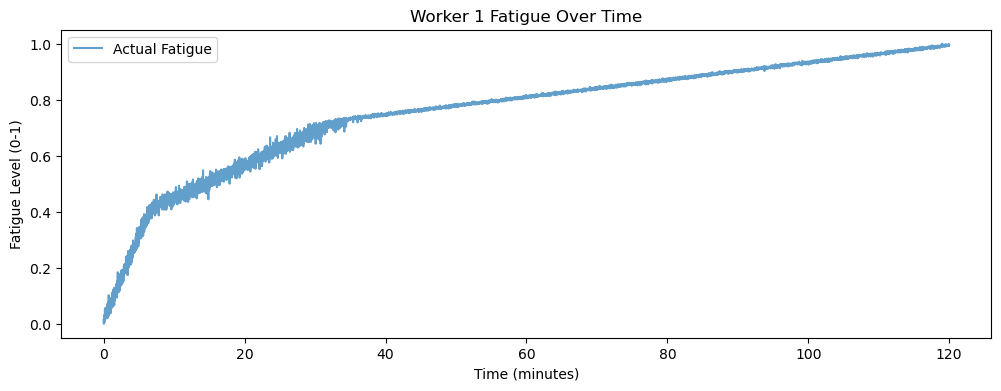

In [43]:
import matplotlib.pyplot as plt

worker_id = 1  # pick a worker
df_worker = df_all[df_all['worker_id'] == worker_id].sort_values("time_s")

plt.figure(figsize=(12,4))
plt.plot(df_worker['time_s']/60, df_worker['fatigue_now'], label='Actual Fatigue', alpha=0.7)
plt.xlabel('Time (minutes)')
plt.ylabel('Fatigue Level (0-1)')
plt.title(f'Worker {worker_id} Fatigue Over Time')
plt.legend()
plt.show()


### Multi-Horizon Predictions vs Ground Truth

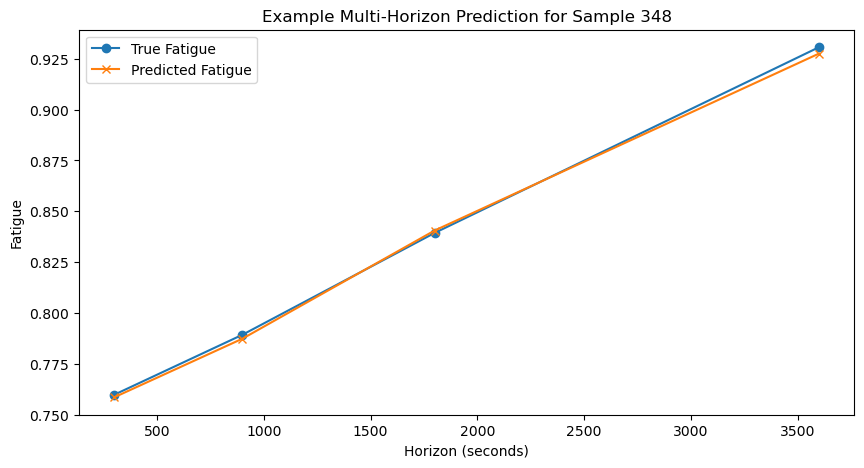

In [54]:
import random
i = random.randint(0, len(Y_vl)-1)

plt.figure(figsize=(10,5))
plt.plot(HORIZONS, Y_vl[i], 'o-', label='True Fatigue')
plt.plot(HORIZONS, Y_pred[i], 'x-', label='Predicted Fatigue')
plt.xlabel('Horizon (seconds)')
plt.ylabel('Fatigue')
plt.title(f'Example Multi-Horizon Prediction for Sample {i}')
plt.legend()
plt.show()


### Feature Correlation Heatmap

This checks which physiological features correlate most with fatigue.

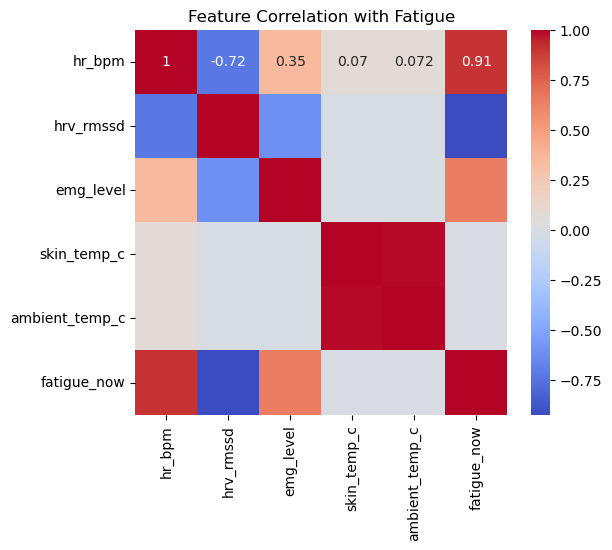

In [55]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(df_all[feature_cols + [target_col]].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Fatigue')
plt.show()


### Fatigue Distribution & Early Warning

This visualizes how often workers hit high fatigue (ROF≥8)

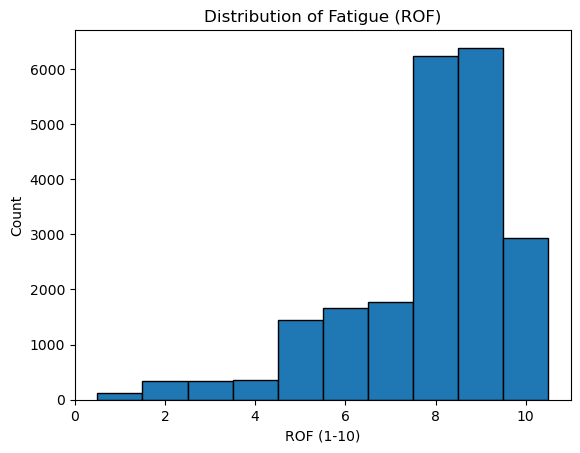

In [57]:
rof = fatigue_to_rof_arr(df_all['fatigue_now'])
plt.hist(rof, bins=np.arange(1,12)-0.5, edgecolor='k')
plt.xlabel('ROF (1-10)')
plt.ylabel('Count')
plt.title('Distribution of Fatigue (ROF)')
plt.show()


## Heatmap of Worker Fatigue Across Time

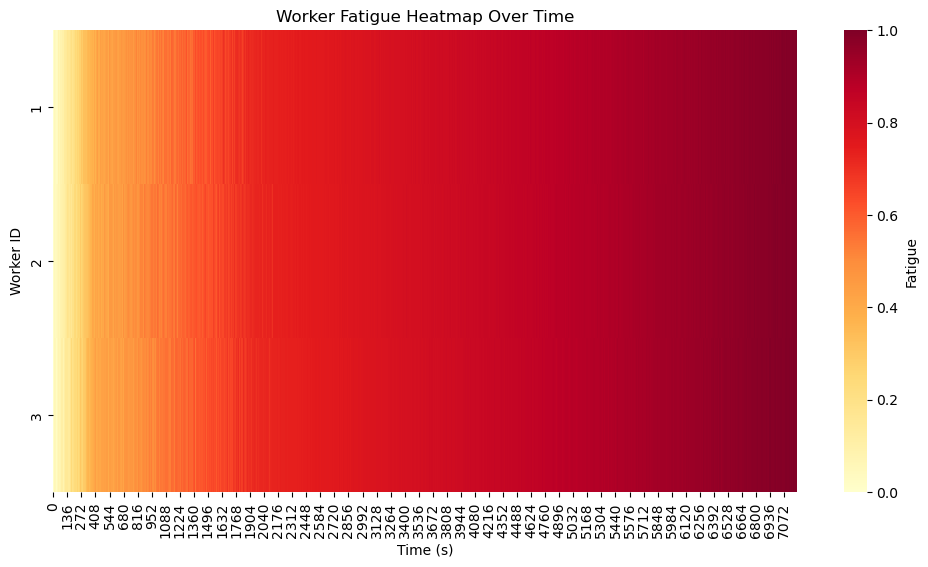

In [58]:
pivot = df_all.pivot(index='worker_id', columns='time_s', values='fatigue_now')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Fatigue'})
plt.xlabel('Time (s)')
plt.ylabel('Worker ID')
plt.title('Worker Fatigue Heatmap Over Time')
plt.show()


## 8) Save TorchScript model (for dashboards / services)

In [41]:
feature_cols = ["hr_bpm","hrv_rmssd","emg_level","skin_temp_c","ambient_temp_c"]


In [42]:
import torch, os

# --- Step 0: define feature columns exactly as used in training
feature_cols = ["hr_bpm","hrv_rmssd","emg_level","skin_temp_c","ambient_temp_c"]

# --- Step 1: ensure model exists in memory
# Replace this line with your trained model if it's not defined
# from previous cells: model = LSTMForecasterMH(...); model trained already
device = "cpu"  # use "cuda" if you have GPU

# --- Step 2: create artifacts folder if not exists
os.makedirs("artifacts", exist_ok=True)

# --- Step 3: save PyTorch state_dict (optional, backup)
torch.save(model.state_dict(), "artifacts/fatigue_lstm_mh.pt")

# --- Step 4: create example input and trace TorchScript
example = torch.zeros(1, 60, len(feature_cols), dtype=torch.float32).to(device)
traced = torch.jit.trace(model, example)

# --- Step 5: save TorchScript model
traced.save("artifacts/fatigue_lstm_mh.ts")

print("Saved both PyTorch (.pt) and TorchScript (.ts) models in 'artifacts/'")


Saved both PyTorch (.pt) and TorchScript (.ts) models in 'artifacts/'


# Challenges & limitations



Stronger validation: use leave‑one‑subject‑out (LOSO) splits to estimate cross‑subject generalization.

Calibration & uncertainty: add probabilistic outputs (e.g., MC‑dropout, ensembling) and compute calibration metrics / reliability diagrams.

Feature engineering: add time‑domain features (rolling means, slopes, spectral HRV features) and test a shallow model baseline (RF / XGBoost) for comparison.

Robustness to missing data: implement imputation, masking, or a model that accepts variable length / masked input.

Deployability: wrap TorchScript model in a small service (FastAPI) and push predictions to a dashboard. Add unit tests for inference helpers.

User studies: test whether the early warnings lead to measurable safety improvements or behavioral changes on site.

# Recommendations & future work



Class imbalance & label distribution: some horizons had very skewed class balances (e.g., only positives at +60m in the run) which prevents reliable discrimination metrics.

Overfitting / data leakage risk: extremely low validation MSE and almost perfect AUROC can be a sign of leakage (e.g., temporal leakage when overlapping windows are split incorrectly) or dataset ease. Verify that validation windows are strictly separated from training sessions per worker/time.

Small dataset / subject variability: generalization to new workers or different tasks is untested — require cross‑subject validation.

Sensor noise & missing data: real wearable deployments have dropouts and noise; the notebook currently assumes clean data.

Label reliability: fatigue_now originates from ROF prompts — subjective labels may be noisy and biased.

# Conclusion

This project demonstrates a compact pipeline for short‑horizon fatigue forecasting using wearable signals. A multi‑horizon LSTM forecaster successfully maps 60s windows of physiological data to fatigue forecasts at +5, +15, +30 and +60 minutes and produces interpretable ROF alerts suitable for supervisor dashboards. While demo results are promising, careful validation (LOSO), mitigation of label noise, and robustness checks against sensor drift are required before field deployment. Future work should prioritize cross‑subject validation, calibration of predicted probabilities, and field trials to measure real safety impact.